In [1]:
from keras.utils.data_utils import get_file

database_path = 'train/'

dl_file='dl2017-image-proj.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=database_path, extract=True)

Using TensorFlow backend.


279142400/279523357 [============================>.] - ETA: 0s

'./train/dl2017-image-proj.zip'

## Team Raspberry - image project

In [2]:
from keras.utils.data_utils import get_file
import matplotlib.pylab as plt
import numpy as np
from scipy.misc import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss, average_precision_score
from sklearn.utils import class_weight

We read the labels as y and transform the labels into 14 + 1, where the extra one is label for the unclassified data.

In [3]:
image_count = 20000
image_dim = (128, 128, 3) # 128 x 128; RGB

print('cell run')
#%% Form y

num_classes = 14 + 1
UNCLASSIFIED_BIT = 14
labels = {
  0: 'baby',
  1: 'bird',
  2: 'car',
  3: 'clouds',
  4: 'dog',
  5: 'female',
  6: 'flower',
  7: 'male',
  8: 'night',
  9: 'people',
  10: 'portrait',
  11: 'river',
  12: 'sea',
  13: 'tree',
  UNCLASSIFIED_BIT: "unclassified"
}

labels_rev = {v: k for k, v in labels.items()}

# The labels are made into onehot vectors straight away
y = np.zeros((image_count, num_classes), dtype="uint8")

folder = "train/annotations/"
for num, label in labels.items():
    if num == UNCLASSIFIED_BIT:
        continue
    with open(folder + label +".txt", "r") as f:
        for line in f.readlines():
            # The indexing starts from 1 in dataset, but is converted to starting from 0
            y[int(line.strip())-1, num] = 1

for row in y:
    if sum(row) == 0:
        row[UNCLASSIFIED_BIT] = 1

print('classes and y labels created')

cell run
classes and y labels created


We can clearly see that some of the labels never co-exists together.

In [16]:
###
# Finding "mutually exclusive" item
###

find_mutex = True
if find_mutex:
    # track mutually exclusive items
    #from scipy.misc import imshow
    from matplotlib.pyplot import imshow
    mutex = np.zeros((num_classes-1,num_classes-1), dtype=np.uint8)
    BI_MUTEX = np.zeros((num_classes-1, num_classes-1), dtype=np.float32)

    def _get_all_indices(list_vals, spec_val):
        return [i for i,x in enumerate(list_vals) if x == spec_val]

    for row in y:
        one_indices = _get_all_indices(row[:-1], 1)
        for i in one_indices:
            for j in one_indices:
                mutex[i,j] += 1
                BI_MUTEX[i,j] = 1.0
                
    #print(mutex)
    #mutex /= max(mutex)
    imshow(mutex, cmap='Greys')

    for i in range(len(mutex)):
        nonzero = [labels[j] for j,x in enumerate(mutex[i]) if x == 0]
        print('%10s:\t%s' % (labels[i],nonzero))


    print(mutex)
    print(BI_MUTEX)

print('mutexes enumerated')


      baby:	['bird', 'car', 'clouds', 'dog', 'flower', 'night', 'river', 'sea', 'tree']
      bird:	['baby', 'car', 'dog', 'night', 'river']
       car:	['baby', 'bird', 'flower', 'river']
    clouds:	['baby']
       dog:	['baby', 'bird', 'night', 'river']
    female:	[]
    flower:	['baby', 'car', 'night', 'river', 'sea']
      male:	[]
     night:	['baby', 'bird', 'dog', 'flower', 'sea']
    people:	[]
  portrait:	[]
     river:	['baby', 'bird', 'car', 'dog', 'flower']
       sea:	['baby', 'flower', 'night']
      tree:	['baby']
[[ 95   0   0   0   0  23   0  43   0  94  80   0   0   0]
 [  0 104   0   8   0   8   3   8   0  15   5   0   3  16]
 [  0   0  63  14   2  13   0  20  11  42   4   0   1   1]
 [  0   8  14  71   2  31   6  60  17 139  17  28  42  48]
 [  0   0   2   2 192  23   2  27   0  54  21   0   2   2]
 [ 23   8  13  31  23 155  26  69  11  94 154   4  15  12]
 [  0   3   0   6   2  26 249   9   0  29  18   0   0  25]
 [ 43   8  20  60  27  69   9 163  32 112  47   8 

Reading happens by this function in batches. This helps to avoid filling the whole RAM.

In [5]:
# normalizing range to be in 0.0 to 1.0
my_dtype = "uint8"
normalize_values = True

my_dtype = "uint8"
if normalize_values:
    my_dtype = np.float32

def read_x(batch_size, begin_index, y):
    x_color = np.zeros((batch_size, *image_dim), dtype=my_dtype)
    end_index = begin_index + batch_size

    for i in range(begin_index, end_index):
        img = imread("train/images/im" + str(i+1) +".jpg")
        if normalize_values:
            img = img / 255
        if len(img.shape) == 3:
            x_color[i-begin_index] = img
        else:    
            x_color[i-begin_index] = np.repeat(img[:,:,np.newaxis], 3, axis=2) # B&W RGB representation

    return x_color, y[begin_index:end_index,:]

print('read_x defined')

#%% Sanity check x-reader

x_testing, y_testing = read_x(2000, 2000, y)
print(x_testing.shape)


read_x defined
(2000, 128, 128, 3)


By plotting the labels we can see that they aren't equally distributed. This creates a need for the custom weight. Clearly almost half of the images are unclassified. People label is also quite heavily dominating.
![label distribution](presentation/images/label_distribution.png "Labels")

Total amount of labels: 30048
Amount of images with no class: 9824
Amount of images per class:
[('baby', 95), ('bird', 360), ('car', 319), ('clouds', 1095), ('dog', 448), ('female', 3227), ('flower', 761), ('male', 2979), ('night', 598), ('people', 6403), ('portrait', 3121), ('river', 120), ('sea', 173), ('tree', 525), ('unclassified', 9824)]


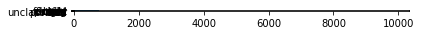

In [6]:

def get_label_statistics():
    total = np.sum(y)
    count_per_label = y.sum(axis=0)
    unlabeled_images = count_per_label[UNCLASSIFIED_BIT]
    label_count = [(x, count_per_label[i]) for (i,x) in enumerate(labels_rev.keys())]
    print("Total amount of labels: %s" % total)
    print("Amount of images with no class: %d" % unlabeled_images)
    print("Amount of images per class:")
    print(label_count)
    l, c = zip(*label_count)
    plt.barh(np.arange(0, num_classes), c, tick_label=l)
        

get_label_statistics()
plt.show()


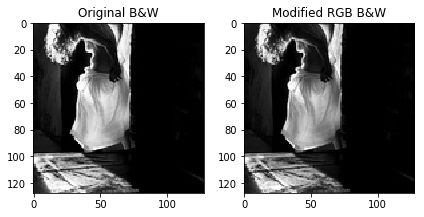

In [7]:
# Sanity check for black-and-white images

plt.subplot(1,2,1)
plt.imshow(imread("train/images/im7.jpg"), cmap='Greys_r', interpolation='none')
plt.title("Original B&W")

plt.subplot(1,2,2)
plt.imshow(np.repeat(imread("train/images/im7.jpg")[:,:,np.newaxis], 3, axis=2))
plt.title("Modified RGB B&W")

plt.tight_layout()
plt.show()

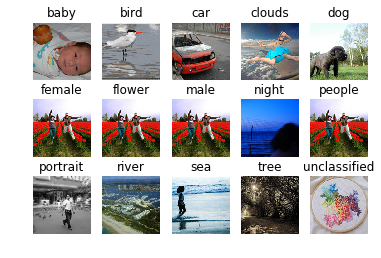

In [8]:
# Some plotting of first instances of each class

for l in range(num_classes):
    idx = np.argwhere(y_testing[:,l]==1)[0]
    
    
    plt.subplot(3, 5, l+1)
    
    img = x_testing[idx].reshape(128, 128, 3)
        
    plt.imshow(img)
    plt.title(labels[l])
    plt.axis('off')

plt.show()

In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
print('model imports done')

model imports done


F1-score implementation in Keras. Used while training.

In [10]:
# Evaluators

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+ K.epsilon()))

Custom loss function called *BP-MLL (Backpropagation for Multilabel Learning)* which was introduced in Min-Ling Zhang and Zhi-Hua Zhou, "Multilabel Neural Networks with Applications to Functional Genomics and Text Categorization," in IEEE Transactions on Knowledge and Data Engineering, vol. 18, no. 10, pp. 1338-1351, Oct. 2006. 

Designed for multilabeled problems and punishes the model more from giving the wrong labeling.

Formally defined as $$ E =  \sum_{i=1}^{m} \dfrac{1}{|Y_i||\bar{Y_i}|} \sum_{(k,l) \in Y_i \times \bar{Y_i}} \exp(-(c_k^i -c_l^i))$$



In [17]:
# bp mll loss function
# y_true, y_pred must be 2D tensors of shape (batch dimension, number of labels)
# y_true must satisfy y_true[i][j] == 1 iff sample i has label j
def bp_mll_loss(y_true, y_pred):
 
    # get true and false labels
    y_i = K.equal(y_true, K.ones_like(y_true))
    y_i_bar = K.not_equal(y_true, K.ones_like(y_true))
    
    # cast to float as keras backend has no logical and
    y_i = K.cast(y_i, dtype='float32')
    y_i_bar = K.cast(y_i_bar, dtype='float32')

    # get indices to check
    truth_matrix = pairwise_and(y_i, y_i_bar)

    # calculate all exp'd differences
    sub_matrix = pairwise_sub(y_pred, y_pred)
    exp_matrix = K.exp(-sub_matrix)

    # check which differences to consider and sum them
    sparse_matrix = exp_matrix * truth_matrix
    sums = K.sum(sparse_matrix, axis=[1,2])

    # get normalizing terms and apply them
    y_i_sizes = K.sum(y_i, axis=1)
    y_i_bar_sizes = K.sum(y_i_bar, axis=1)
    normalizers = y_i_sizes * y_i_bar_sizes
    results = sums / normalizers
    pseudo_f1 = f1(y_true, y_pred)
    pseudo_f1 = K.switch(pseudo_f1, K.epsilon(), pseudo_f1)
    
    # sum over samples
    sum_over_samples = K.sum(results)
    
    return sum_over_samples

# compute pairwise differences between elements of the tensors a and b
def pairwise_sub(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return column - row

# compute pairwise logical and between elements of the tensors a and b
def pairwise_and(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return K.minimum(column, row)

import tensorflow as tf
def mutex_loss(y_true, y_pred):
    # global BI_MUTEX
    diff = tf.subtract(y_true, y_pred)
    norm_all = tf.matmul(diff.T, diff)
    norm_14 = tf.matmul(diff[:-1].T, diff[:-1])
    return norm_all + (norm_14 * tf.matmul(BI_MUTEX, diff))

def f1_loss(y_true, y_pred):
    return 1.0 - f1(y_true, y_pred)

def custom_loss(y_true, y_pred):
    return (bp_mll_loss(y_true, y_pred) +
            (mutex_loss(y_true, y_pred) / 50.0) +
            (50 * f1_loss(y_true, y_pred)))

The final model.

In [39]:
# Testing/Submission-ready Model
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3))) #, input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3))) #, input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(num_classes))
model.add(Activation("sigmoid"))


my_loss = bp_mll_loss
my_optimizer = RMSprop(lr=0.002)
my_metrics = ['binary_accuracy', "categorical_accuracy", f1]
# binary_crossentropy
model.compile(loss=my_loss, 
              optimizer=my_optimizer, 
              metrics=my_metrics)


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
activation_21 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
activation_22 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        9248      
__________

We use image augmentor to create more varying set and make the learning even more challenging for the model.

In [34]:
train_datagen = ImageDataGenerator(
                samplewise_center=True,
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                )

print('data generator defined')


data generator defined


As stated early above, we have to use custom class weights to deal with imbalanced classes. Class weights are calculated per batch and defined as $$S(c_i;\lambda) = \ln\left(\lambda \dfrac{\sum_{c}|c|}{|c_i|}\right)\\\\
	W(c_i; \lambda) = \max(S(c_i;\lambda), 1)$$ where $c_i$ is the specific class and $\lambda$ is the weight. This will give the lowest distributed classes the most weight and will punish the model heavily for misclassifying them.

In [35]:
# Create class_weights
import math
def create_class_weight(labels_dict,mu=0.55):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1

    return class_weight

total_sum_y = y.sum(axis=0)
y_max = total_sum_y.max()

labels_dict = {i: (x) for (i, x) in enumerate(total_sum_y)}
cw = create_class_weight(labels_dict)

We read the data in batches and use 2 epochs per augmented data. This will also make the first and second epoch train sets different thanks to augmentor.

In [36]:
batch_size = 2000
iterations = [i * batch_size for i in range(int(image_count / batch_size))]  # can go up to 20000
overall_history = []
x_test, y_test = [], []
epochs = 2
print("Will run for {} iterations".format(len(iterations)))

for i in range(len(iterations)):
    print("I:", i)
    x_some, y_some = read_x(batch_size, iterations[i], y)
    
    x_train, x_val, y_train, y_val = train_test_split(x_some, y_some, test_size=0.1)
    x_test.append(x_val)
    y_test.append(y_val)
    
    total_sum_y = y_train.sum(axis=0)
    labels_dict = {i: (x) for (i, x) in enumerate(total_sum_y)}
    cw = create_class_weight(labels_dict)
    
    
    history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=4),
                                    steps_per_epoch=len(x_train) / 4, 
                                    epochs=epochs,
                                    validation_data=(x_val, y_val),
                                    class_weight=cw)
    overall_history.append(history)

# Flat arrays of numpy arrays
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
#%% Model evaluation

scores = model.evaluate(x_test, y_test, verbose=2)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

Will run for 10 iterations
I: 0
Epoch 1/2
450/450 [==============================] - 24s - loss: 5.3096 - binary_accuracy: 0.8669 - categorical_accuracy: 0.0333 - f1: 0.4329 - val_loss: 3.0357 - val_binary_accuracy: 0.8677 - val_categorical_accuracy: 0.0350 - val_f1: 0.4221
Epoch 2/2
450/450 [==============================] - 23s - loss: 5.2694 - binary_accuracy: 0.8676 - categorical_accuracy: 0.0261 - f1: 0.4348 - val_loss: 3.0357 - val_binary_accuracy: 0.8677 - val_categorical_accuracy: 0.0350 - val_f1: 0.4221
I: 1
Epoch 1/2
450/450 [==============================] - 21s - loss: 4.9401 - binary_accuracy: 0.8722 - categorical_accuracy: 0.0356 - f1: 0.4617 - val_loss: 2.8977 - val_binary_accuracy: 0.8720 - val_categorical_accuracy: 0.0100 - val_f1: 0.4485
Epoch 2/2
450/450 [==============================] - 19s - loss: 4.9547 - binary_accuracy: 0.8722 - categorical_accuracy: 0.0356 - f1: 0.4629 - val_loss: 2.8977 - val_binary_accuracy: 0.8720 - val_categorical_accuracy: 0.0100 - val_f1

We tried out different parameters and the summarization can be seen below. Basically none of the parametrization tryouts gave better results as the simple model we used. Interestingly some of the activation functions gave even poorer results than a simple ReLu. Also making the network more deeper wouldn't help.

### Reparameterizations and their resulting changes Scores

0. "Default"
    - 3 convolutions, 1 dense layer
    - RMSprop optimizer (default lr)
    - F1: 0.462374821173
    - Hamming loss: 0.12526666666666667
1. Increased deeply-connected layers
    - included 2 more Dense layers each with dropout(0.4) and of size 1.5*num_classes, and 2*num_classes (shrinking sizes towards _num_classes)
    - nearly twice as many trainable parameters as default
    - F1: 0.452017681449
    - Hamming loss: 0.1281
    - filename: inc_deep_conn_lay.png
2. Adagrad optimizer
    - using adagrad optimizer instead of RMSprop
    - F1: 0.459641577061
    - Hamming loss: 0.12563333333333335
    - filename: adagrad_opt.png
3. Nadam optimizer
    - using Nadam optimizer instead of RMSprop
    - F1: 0.469881241952
    - Hamming loss: 0.1235
    - filename: nadam_opt.png
4. More Convolutions
    - added an earlier convolutional layer with 16 features at beginning of network
    - roughly halves trainable params
    - takes about 75% as long to train
    - all other parameters same as default
    - F1: 0.462928438262
    - Hamming loss: 0.12483333333333334
    - filename: early_small_conv.png
5. Even More Convolutions:
    - added another 16-feature convolutional layer after intro layer
    - 39K trainable params (I think same as 1 extra convolution; TODO: check this)
    - all other params same
    - a couple more seconds improvement per batch over No.4
    - F1: 0.462281574087
    - Hamming loss: 0.12616666666666668
    - filename: even_more_conv.png
6. Reverse Convolution Triangle
    - Use the largest layer first, then gradually go down to smallest layer
    - Take No.4, but reverse convolutional layers (64->32->32->16)
    - 42K trainable params
    - training time worse than original network (aggravatingly slow)
    - F1: 0.463071011812
    - Hamming loss: 0.12576666666666667
    - filename: rev_conv_tri.png
7. Learning Rate Changes:
    - Using Network No.4
    - Learning Rates:
        - Default = 0.001: see No.4
        - lr=0.0005
            - F1: 0.464398055476
            - Hamming loss: 0.12486666666666667
            - filename: rmsprop_lr__0.0005_.png
        - lr=0.000333
            - F1: 0.457404230989
            - Hamming loss: 0.12653333333333333
            - filename: rmsprop_lr__0.000333_.png
        - lr=0.002:
            - F1: 0.465169503648
            - Hamming loss: 0.12463333333333333
            - filename: rmsprop_lr__0.002_.png
        - lr=0.005:
            - F1: 0.457308248915
            - Hamming loss: 0.125
            - filename: rmsprop_lr__0.005_.png
8. Using different activation functions:
    - Leaky Relu (using alpha as 0.3)
        - F1: 0.0837198604669
        - Hamming loss: 0.7967666666666666
        - filename: leaky_relu.png
    - Tanh
        - F1: 0.378796368934
        - Hamming loss: 0.18476666666666666
        - filename: relu_to_tanh.png

In [37]:
# Choose the best treshold

pred = model.predict(x_test)
thresholds = [0.1, 0.25, 0.75, 0.8, 0.95, 0.5]
tres_scores = []
for threshold in thresholds:
    y_pred = np.copy(pred)
    y_pred[np.where(y_pred > threshold)] = 1
    y_pred[np.where(y_pred <= threshold)] = 0
    f1_thres = f1_score(y_test, y_pred, average='micro')
    tres_scores.append((threshold, f1_thres))

tres_scores.sort(key=lambda x: x[1]) # sort by f1 score
best_tres = tres_scores[-1][0]
print("Set best treshold as {}".format(best_tres))

y_pred = np.copy(pred)
y_pred[np.where(y_pred > best_tres)] = 1
y_pred[np.where(y_pred <= best_tres)] = 0
print("F1:", f1_score(y_test, y_pred, average='micro'))
print("Hamming loss:", hamming_loss(y_test, y_pred))
print(str(average_precision_score(y_test, y_pred, average="micro")))

Set best treshold as 0.5
F1: 0.457308248915
Hamming loss: 0.125
0.258800687285


From the plots, it's quite visible that the loss is somewhat going down (wildly), but the f1-score (orange) is basically stable. This is because the model overfits too much to major labels even with custom class weights. Also the fact that unclassified images often contains same looking images as in other, already existing labels, makes the model behave badly.  

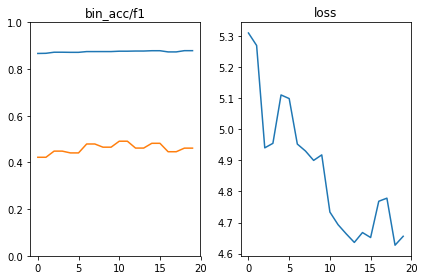

In [38]:
def plot_train_metrics():
    plt.subplot(1,2,1)
    bin_acc_per_epoch = np.array([e.history['binary_accuracy'] for e in overall_history]).flatten()
    plt.plot(bin_acc_per_epoch)
    plt.title("binary_acc")
    plt.subplot(1,2,2)
    loss_per_epoch = np.array([e.history['loss'] for e in overall_history]).flatten()
    plt.plot(loss_per_epoch)
    plt.title("loss")
    plt.subplot(1,2,1)
    loss_per_epoch = np.array([e.history['val_f1'] for e in overall_history]).flatten()
    plt.plot(loss_per_epoch)
    plt.title("bin_acc/f1")
    plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig('./out_imgs/rmsprop_lr__0.005_.png')
    plt.show()
    
plot_train_metrics()

It's visible from the confusion matrices per label, that our model got overfitted to people and unclassified. This could have been maybe avoided by creating one network per one label. 

![label distribution](presentation/images/conf_bpmll.png "Labels")

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(num_classes):
    
    plt.subplot(3, 5, i+1)
    
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test[:,i], y_pred[:,i]).ravel()
    
    matrix = np.zeros((2,2), dtype="uint32")
    matrix[0,0] = true_pos
    matrix[0,1] = false_neg
    matrix[1,1] = true_neg
    # sanity check: bottom left, predicted pos, true was neg
    matrix[1,0] = false_pos

    plt.imshow(matrix, 
               cmap=plt.cm.Blues, 
               interpolation='nearest',
               vmin=0, vmax=10000)

    for j in range(2):
        for k in range(2):
            plt.text(k, j, str(matrix[j,k]),
                        fontsize=15,
                        horizontalalignment='center',
                        verticalalignment='center')

    classes = ["Pos", "Neg"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.title(labels[i], fontsize=15)
    

plt.tight_layout()
plt.show()

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
model.save('model.h5')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

The testset (images only) can now be downloaded with the following commands:

In [ ]:
from keras.utils.data_utils import get_file

testset_path = 'test/'

dl_file='dl2017-image-test.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=testset_path, extract=True)

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` (e.g., by calling `y=model.predict(x_test)`) you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')